# Model 3

# Age Related Macular Degeneration  CNN Binary Model 

## Mark Whelly - BrainStation Data Science Bootcamp - August 2022

Transfer Learning Model using InceptionV3. Working on Google Colab Cloud environment.

This is the third of 5 models presented as part of this project.

This MODEL 3 is a binary classifier of retinal images, specifically looking for Age-Related Macular Degeneration.
ARMD is a very prevalent eye disease associated with loss of central vision over time, and is a leading cause of vision loss.
There are a number of indicators of this ARMD condition including multiple drusen in macular region, geographic atrophy involving the fovea, features of neovascular age-related macular degeration.

This CNN model only includes the images that show either:
    -Normal eye condition (class 0).
    -ARMD only (class1). No other disease present.

The data originate from a scientific paper in the journal Data, as published by Pachade et al 2021. Data was obtained from the kaggle website, as provided by the user 'Larxel' under the dataset Retinal Image Classification.

All modeling work was done on the Google Colab environment using google GPU to increase modeling speeds.

In [1]:
import os

In [2]:
from google.colab import drive

In [3]:
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
cd/gdrive/My Drive/Retimages/Train/

/gdrive/My Drive/Retimages/Train


In [5]:
import numpy as np 
import pandas as pd
import zipfile

import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.python.keras.models import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from pathlib import Path
import os

import skimage
import skimage.io
from skimage import data, img_as_float
from skimage import exposure
from matplotlib import pyplot as plt

from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist

In [6]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD
except:
    !pip install keras
    !pip install h5py==3.1.0 numpy==1.19.2 six==1.15.0 typing-extensions==3.7.4 wrapt==1.12.1 botocore==1.20.106 gast==0.4.0 tensorboard==2.6 tensorflow-estimator==2.6 absl-py==0.9 protobuf==3.11.2 scikit-learn==0.24 fsspec==2021.07.0 google-api-python-client==1.12.1
    !pip install --upgrade tensorflow
    !pip install --ignore-installed --upgrade tensorflow-gpu==1.15.0
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD

In [7]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shutil
from tqdm import tqdm

# PART 1 - Data Preparation and Organization

Grouping images into 2 separate folders (0 for Normal photos, and 1 for ARMD images), within Retimages/Train/TrainARMDonly directory on Google Colab.

Similarly, Validation images were grouped into subfolder per 2 classes, within Retimages/Validation/ValidARMDonly, and Test images grouped into Retimages/Test/TestARMDonly.

Note that image preprocessing was conducted on all images and the model was run and compared with the model using the original non-enhanced images. In this case, the best results (recall, precision, accuracy) were seen with the non-enhanced images and this is shown below.

In [16]:
# ALREADY RUN, do not rerun. 

# This code grouped images into 2 folders.

# TRAINING IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[] 

# ARMD_Only, based on a 1 in col 1.
b=[] 

# Remaining Disease combos are a 2 in col 1. (these will not be used)
#c= []

with open('../Train/TrainARMD_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # armd_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./TrainARMDonly')

parent_dir="./TrainARMDonly"
directory1 = "0Normal" 
directory2 = "1ARMDonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [17]:
# ALREADY RUN, do not rerun. 

save_path = './TrainARMDonly/0Normal'
for filename in a:
  shutil.copy('Training_set/'+filename,save_path)

save_path = './TrainARMDonly/1ARMDonly'
for filename in b:
  shutil.copy('Training_set/'+filename,save_path)

In [22]:
cd/gdrive/My Drive/Retimages/Validation/

/gdrive/My Drive/Retimages/Validation


In [23]:
# ALREADY RUN, do not rerun. 

# This code grouped images into 2 folders.

# VALIDATION IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode'), goes in '0_Normal'
a=[]

# ARMD_Only, based on a 1 in col 1 ('DisCode').
b=[]

# Remaining Disease combos are a 2 in col 1. (these will not be used)

with open('../Validation/Valid_ARMD_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # ARMD_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./ValidARMDonly')

In [24]:
# ALREADY RUN, do not rerun. 

parent_dir="./ValidARMDonly"
directory1 = "0Normal" 
directory2 = "1ARMDonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [25]:
# ALREADY RUN, do not rerun. 

save_path = './ValidARMDonly/0Normal'
for filename in a:
  shutil.copy('Validation_set/'+filename,save_path)
save_path = './ValidARMDonly/1ARMDonly'
for filename in b:
  shutil.copy('Validation_set/'+filename,save_path)

In [26]:
cd/gdrive/My Drive/Retimages/Test/

/gdrive/My Drive/Retimages/Test


In [27]:
# ALREADY RUN, do not rerun. 

# TEST IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[]

# ARMD_Only, based on a 1 in col 1.
b=[]

# Remaining Disease combos are a 2 in col 1. (these will not be used)

with open('../Test/Test_ARMD_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # ARMD_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./TestARMDonly')

In [28]:
# ALREADY RUN, do not rerun. 

parent_dir="./TestARMDonly"
directory1 = "0Normal" 
directory2 = "1ARMDonly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [29]:
# ALREADY RUN, do not rerun. 

save_path = './TestARMDonly/0Normal'
for filename in a:
  shutil.copy('Test_set/'+filename,save_path)
save_path = './TestARMDonly/1ARMDonly'
for filename in b:
  shutil.copy('Test_set/'+filename,save_path)

In [10]:
cd/gdrive/My Drive/Retimages/

/gdrive/My Drive/Retimages


In [11]:
from google.colab.patches import cv2_imshow

In [ ]:
# to move all my augmented files from aug folder to 0Normal Validation folder

import shutil
import os
    
source_dir = '/gdrive/My Drive/Retimages/Train/TrainDRONLY/Aug/'
target_dir = '/gdrive/My Drive/Retimages/Train/TrainDRONLY/1DRonly/'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
  shutil.move(os.path.join(source_dir, file_name), (target_dir, file_name))

TypeError: ignored

In [54]:
# TO AUGMENT NUMBER OF IMAGES based on imbalanced classes:

# already run this

#  Do not rerun


from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 30,
        vertical_flip = True,
        horizontal_flip = True,
        brightness_range = (1, 1.1))
import numpy as np
import os
from PIL import Image

# augmenting TRAIN ARMD set of  pics:
image_directory = os.path.join('./Test/TestARMDonly/1ARMDonly/')
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'png'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((536,356)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=18,
                          save_to_dir= os.path.join('./Test/TestARMDonly/Aug/'),
                          save_prefix='dr4',
                          save_format='png'):    
    i += 1    
    if i > 0:        
        break

In [13]:
# count files per group

train_abnormal_dir = os.path.join('./Train/TrainARMDonly/1ARMDonly')
train_normal_dir = os.path.join('./Train/TrainARMDonly/0Normal')
train_abnormal_names = os.listdir(train_abnormal_dir)
train_normal_names = os.listdir(train_normal_dir)
print('total training images with ARMD:', len(os.listdir(train_abnormal_dir)))
print('total training images of normal eyes:', len(os.listdir(train_normal_dir)))

total training images with ARMD: 232
total training images of normal eyes: 401


In [14]:
Num_Train_Images = len(os.listdir(train_abnormal_dir)) + len(os.listdir(train_normal_dir))
Num_Train_Images

633

In [15]:
validation_abnormal_dir = os.path.join('./Validation/ValidARMDonly/1ARMDonly')
validation_normal_dir = os.path.join('./Validation/ValidARMDonly/0Normal')
validation_abnormal_names = os.listdir(validation_abnormal_dir)
validation_normal_names = os.listdir(validation_normal_dir)
print('total validation images with ARMD:', len(os.listdir(validation_abnormal_dir)))
print('total validation images of normal eyes:', len(os.listdir(validation_normal_dir)))


total validation images with ARMD: 85
total validation images of normal eyes: 134


In [16]:
Num_Validation_Images = len(os.listdir(validation_abnormal_dir)) + len(os.listdir(validation_normal_dir))
Num_Validation_Images

219

In [17]:
test_abnormal_dir = os.path.join('./Test/TestARMDonly/1ARMDonly')
test_normal_dir = os.path.join('./Test/TestARMDonly/0Normal')
test_abnormal_names = os.listdir(test_abnormal_dir)
test_normal_names = os.listdir(test_normal_dir)
print('total Test images with ARMD:', len(os.listdir(test_abnormal_dir)))
print('total Test images of normal eyes:', len(os.listdir(test_normal_dir)))


total Test images with ARMD: 90
total Test images of normal eyes: 134


In [18]:
Num_Test_Images = len(os.listdir(test_abnormal_dir)) + len(os.listdir(test_normal_dir))
Num_Test_Images

224

The dataset was split into train:validation:test sets with 60/20/20 ratios. The ratio of healthy to disease eye images was maintained the same in train, test and validation sets.

## Image Data Generators

In [20]:
# Original (non-equalized) images were used here.

height = 356
width = 536
BATCH_SIZE = 24

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   brightness_range=(1,1.1),
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   fill_mode='constant',
                                   cval = 1)

train_generator = train_datagen.flow_from_directory('./Train/TrainARMDonly', 
                                                    target_size=(height,width), 
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='categorical')


Found 633 images belonging to 2 classes.


In [21]:
# define x_train and y_train from train generator: 
X_train, y_train = train_generator.next() 

In [22]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('./Validation/ValidARMDonly', 
                                                              target_size=(height,width),
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              class_mode='categorical')

Found 219 images belonging to 2 classes.


In [69]:
train_generator.class_indices

{'0Normal': 0, '1ARMDonly': 1}

In [70]:
validation_generator.class_indices

{'0Normal': 0, '1ARMDonly': 1}

# Pretrained CNN Model

In [100]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [102]:
# load InceptionNetV3 model
model=InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(height,width,3))

# Transfer Learning Model

In [103]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False

# select output layer from pretrained models InceptionV3
front_output = model.get_layer('mixed7').output

# Dropout Layer
dl_output = Dropout(0.45)(front_output) 

# add flatten layer and dense layers
flat_output = Flatten()(dl_output)

d1 = Dense(256, activation='relu')(flat_output)
d2 = Dense(128, activation='relu')(d1)
d3 = Dense(64, activation='relu')(d2)
d4 = Dense(16, activation='relu')(d3)
#d5 = Dense(16, activation='relu')(d4)

# add output layer
output = Dense(2, activation='softmax')(d4)  # changed to 2 from 1 class.

# create final model object
model = Model(inputs=model.input, 
              outputs=output)

In [104]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 109, 32)  864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 74, 109, 32)  96         ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                            

### Training the Model

In [105]:
# Apply ReduceLRonPlateau, with RMSprop optimizer.
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
                              patience=1,cooldown=1, min_lr=1e-5)

In [106]:
#compile the InceptionV3 model with Adam or RMSprop or SGD
model.compile(optimizer='RMSprop',loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.3),tf.keras.metrics.AUC()])

In [107]:
# set class weight dictionary for imabalanced training set
classweights = {0:3,1:5}  #0 Normal: 1 ARMD

# set steps for training and steps for validation and fit model

history = model.fit(train_generator,
                    epochs=6,
                    validation_data = validation_generator,
                    batch_size = 18,
                    class_weight = classweights,
                    callbacks=[reduce_lr])


Epoch 1/6
27/27 [==============================] - 88s 3s/step - loss: 3.9697 - binary_accuracy: 0.6643 - auc_4: 0.7084 - val_loss: 0.3048 - val_binary_accuracy: 0.8584 - val_auc_4: 0.9500 - lr: 0.0010
Epoch 2/6
27/27 [==============================] - 81s 3s/step - loss: 1.4685 - binary_accuracy: 0.8167 - auc_4: 0.9092 - val_loss: 1.8792 - val_binary_accuracy: 0.4612 - val_auc_4: 0.5018 - lr: 0.0010
Epoch 3/6
27/27 [==============================] - 81s 3s/step - loss: 1.1687 - binary_accuracy: 0.8578 - auc_4: 0.9365 - val_loss: 0.3980 - val_binary_accuracy: 0.8311 - val_auc_4: 0.9067 - lr: 0.0010
Epoch 4/6
27/27 [==============================] - 81s 3s/step - loss: 0.7477 - binary_accuracy: 0.9226 - auc_4: 0.9739 - val_loss: 0.2367 - val_binary_accuracy: 0.9361 - val_auc_4: 0.9527 - lr: 0.0010
Epoch 5/6
27/27 [==============================] - 81s 3s/step - loss: 0.6310 - binary_accuracy: 0.9352 - auc_4: 0.9771 - val_loss: 0.1932 - val_binary_accuracy: 0.9521 - val_auc_4: 0.9639 - l

# Test Set

In [ ]:
cd/gdrive/My Drive/Retimages/Test

In [108]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('./Test/TestARMDonly',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=224,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 224 images belonging to 2 classes.


# Model Predictions and Evaluation

In [110]:
# Make Predictions, and check shape
predict_probas = model.predict(X_test)
predict_probas.shape

(224, 2)

In [111]:
# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

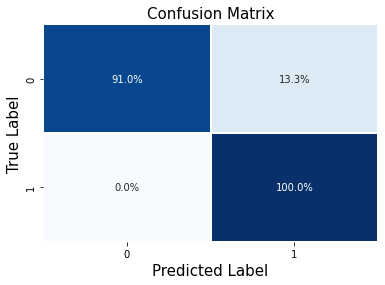

In [112]:
# Construct the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test,axis=1)

conf_mat = confusion_matrix(y_test_labels,y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure()
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            fmt='.1%',
            cmap="Blues",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 15,y=1.01)
plt.xlabel("Predicted Label", size = 15)
plt.ylabel("True Label", size = 15)
plt.show()

The above matrix shows excellent recall and accuracy, and decent precision for detection of ARMD cases in retinal images. See classification report below.

In [113]:
print('F1 Score: %.3f' % f1_score(y_test_labels, y_predict))

F1 Score: 0.938


In [114]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       134
           1       0.88      1.00      0.94        90

    accuracy                           0.95       224
   macro avg       0.94      0.96      0.95       224
weighted avg       0.95      0.95      0.95       224



dict_keys(['loss', 'binary_accuracy', 'auc_4', 'val_loss', 'val_binary_accuracy', 'val_auc_4', 'lr'])


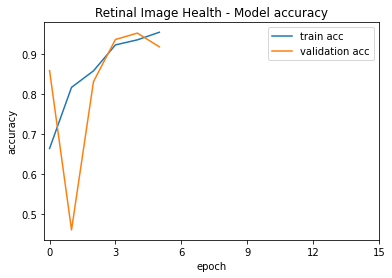

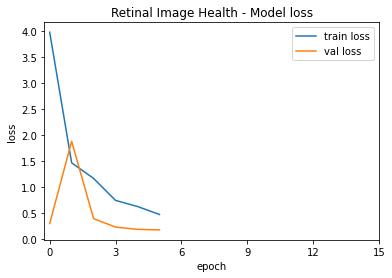

In [115]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Retinal Image Health - ARMD Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train acc', 'validation acc'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Retinal Image Health - ARMD Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train loss', 'val loss'])
plt.show()

In [ ]:
# save model
model.save('Eye_ARMD_Binary__Incept_21Aug2022.h5')

In [ ]:
pip install scikit-plot

In [57]:
# Plot of ROC Curves per Class

from IPython.core.pylabtools import figsize
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(y_test_labels, predict_probas)
plt.figure(figsize=(14,12),dpi=100)
plt.show()

ValueError: ignored

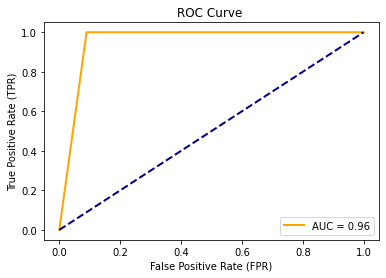

Area under curve (AUC):0.9552238805970149



In [116]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test_labels, y_predict) # need y_proba
roc_auc = roc_auc_score(y_test_labels, y_predict)   #need y_proba

plt.figure()
plt.plot(fprs, tprs, color='orange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - ARMD Model ')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

#### Incorrectly Predicted Images
As our final evaluation of our model, we will look at the images that were incorrectly predicted to see if there are any patterns.

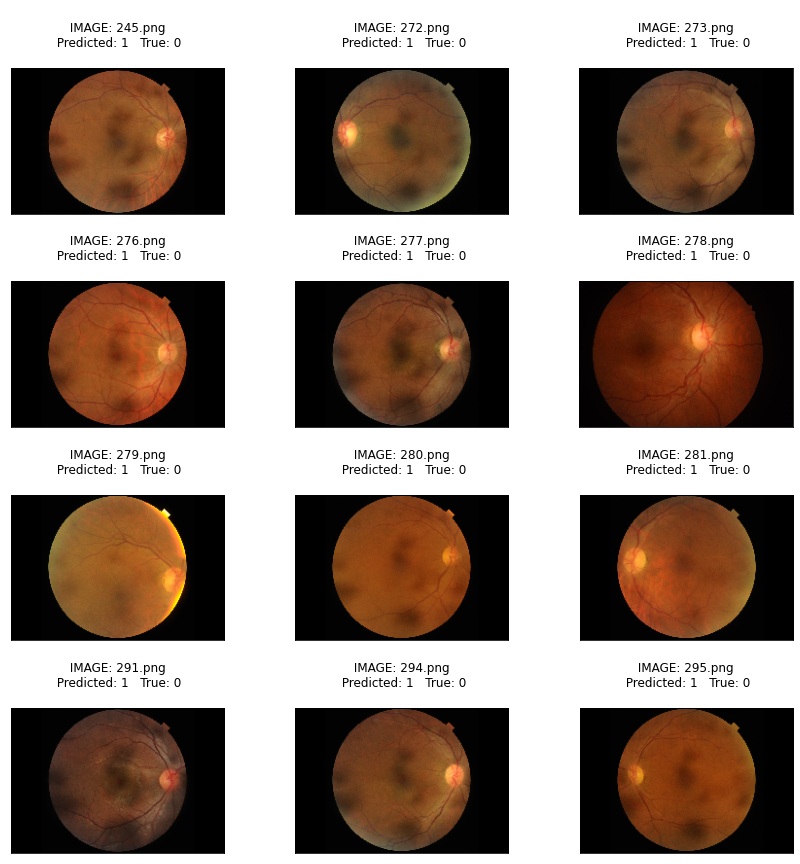

In [117]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(12,3*rows))
axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted = y_predict[incorrect_photos][i]

    # Get actual label
    actual = y_test_labels[incorrect_photos][i]
    
    #Get filename of image
    filenam = test_generator.filenames[i]
    x=filenam[8:]

    # Set the title of the subplot
    axes[i].set_title(f"\n IMAGE: {x} \n Predicted: {predicted}   True: {actual}\n")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()
# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])
plt.show()

In [118]:
# Find all misclassified images in a given test set

MISCLASSIFIED = num_images

# Accuracy calculations
total = Num_Test_Images
num_correct = total - (MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print(f"Number of misclassified images = {MISCLASSIFIED}  out of {total}")

Accuracy: 0.9464285714285714
Number of misclassified images = 12  out of 224


# Concluding Remarks

This model provided great binary classification results for evaluating if eyes are healthy or show signs of Age-Related Macular Degeration. The model showed 100% recall, 88% precision, and 95% test accuracy.